# Importamos bibliotecas necesarias

In [11]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [12]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [13]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [14]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [15]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [16]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [17]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

# Leer el data set desde el archivo csv

In [18]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [19]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [20]:
filtroParaElSubsetDeDatos = ['Bs.As. G.B.A. Zona Oeste']

In [21]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8745 entries, 22 to 109215
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              8745 non-null   object 
 1   place_name                 8745 non-null   object 
 2   price                      8745 non-null   float64
 3   surface_covered_in_m2      8745 non-null   float64
 4   surface_not_covered_in_m2  8745 non-null   float64
 5   price_usd_per_m2           8745 non-null   float64
 6   rooms                      8745 non-null   float64
 7   lat_mediaPorZona           8745 non-null   float64
 8   lon_mediaPorZona           8745 non-null   float64
 9   pileta                     8745 non-null   int64  
 10  cochera                    8745 non-null   int64  
 11  balcon                     8745 non-null   int64  
 12  terraza                    8745 non-null   int64  
 13  parrilla              

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

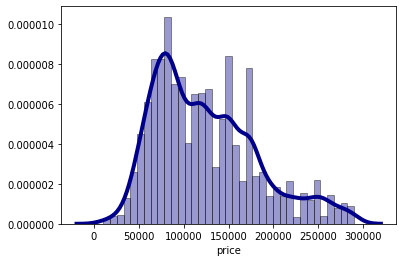

In [22]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


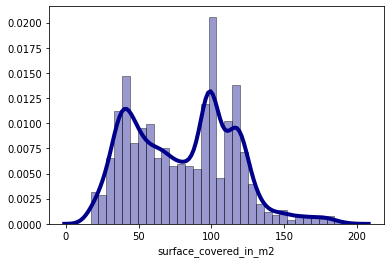

In [23]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

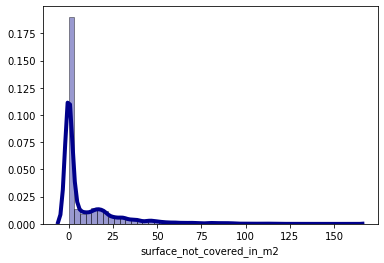

In [24]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

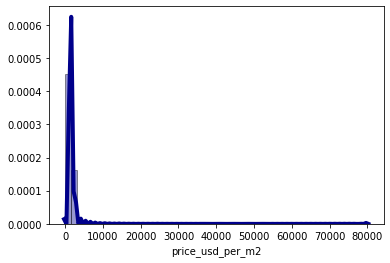

In [25]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

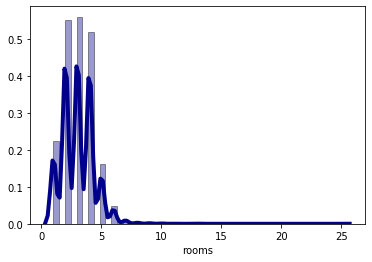

In [26]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [28]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000
mean,124545.731643,80.700089,10.265750,1386.714904,3.041738,-34.637222,-58.673089,0.098113,0.370497,0.168439,0.222070,0.111607
std,57474.547645,35.007948,18.209419,1235.672543,1.321482,0.082555,0.243663,0.297485,0.482966,0.374277,0.415662,0.314900
min,10317.460317,17.000000,0.000000,7.000000,1.000000,-35.323316,-60.513463,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80000.000000,49.000000,0.000000,913.089034,2.000000,-34.654909,-58.666472,0.000000,0.000000,0.000000,0.000000,0.000000
50%,115000.000000,83.000000,0.000000,1300.000000,3.000000,-34.642955,-58.623050,0.000000,0.000000,0.000000,0.000000,0.000000
75%,160000.000000,106.268133,15.499377,1666.666667,4.000000,-34.626671,-58.564128,0.000000,1.000000,0.000000,0.000000,0.000000
max,290000.000000,190.000000,160.000000,80000.000000,25.000000,-34.365371,-58.489889,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 500, 2500)

In [30]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 5)

In [31]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7342 entries, 0 to 7341
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              7342 non-null   object 
 1   place_name                 7342 non-null   object 
 2   price                      7342 non-null   float64
 3   surface_covered_in_m2      7342 non-null   float64
 4   surface_not_covered_in_m2  7342 non-null   float64
 5   price_usd_per_m2           7342 non-null   float64
 6   rooms                      7342 non-null   float64
 7   lat_mediaPorZona           7342 non-null   float64
 8   lon_mediaPorZona           7342 non-null   float64
 9   pileta                     7342 non-null   int64  
 10  cochera                    7342 non-null   int64  
 11  balcon                     7342 non-null   int64  
 12  terraza                    7342 non-null   int64  
 13  parrilla                   7342 non-null   int64

# Analizamos las variables categóricas

ramos mejía                  963
morón                        954
ituzaingó                    612
castelar                     500
haedo                        393
                            ... 
country la tradición           1
terravista barrio privado      1
gonzález catán                 1
la cesarina                    1
barrio cerrado santa ana       1
Name: place_name, Length: 74, dtype: int64


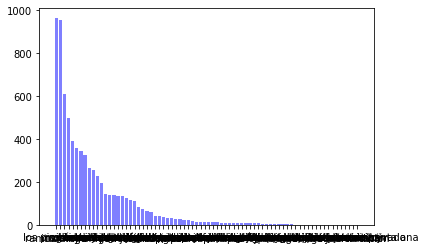

house        3463
apartment    3038
PH            677
store         164
Name: property_type, dtype: int64


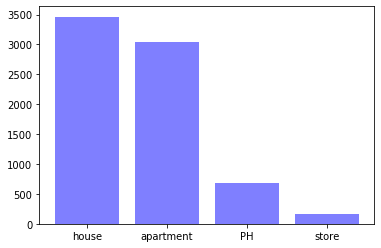

In [32]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [33]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [34]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_villa madero,place_name_villa raffo,place_name_villa sarmiento,place_name_villa tesei,place_name_villa udaondo,place_name_virrey del pino,place_name_william morris,property_type_apartment,property_type_house,property_type_store
0,house,general rodríguez,290000.000000,116.370248,0.0,1450.00000,4.0,-34.607952,-58.934945,1,...,0,0,0,0,0,0,0,0,1,0
1,apartment,castelar,113865.217391,160.000000,0.0,2218.75000,4.0,-34.650579,-58.640534,0,...,0,0,0,0,0,0,0,1,0,0
2,apartment,castelar,113865.217391,160.000000,0.0,2240.93750,4.0,-34.650579,-58.640534,0,...,0,0,0,0,0,0,0,1,0,0
3,apartment,castelar,113865.217391,160.000000,0.0,2263.43750,4.0,-34.650579,-58.640534,0,...,0,0,0,0,0,0,0,1,0,0
4,house,ituzaingó,142612.694378,100.170671,0.0,1423.69711,5.0,-34.626671,-58.666472,0,...,0,0,0,0,0,0,0,0,1,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [35]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_barrio cerrado santa ana,place_name_barrio el moro,place_name_barrio parque san martin,place_name_barrio privado el resuello,place_name_buenos aires,place_name_campos de álvarez,place_name_caseros,place_name_castelar,place_name_ciudad evita,...,place_name_villa bosch,place_name_villa celina,place_name_villa luzuriaga,place_name_villa madero,place_name_villa raffo,place_name_villa sarmiento,place_name_villa tesei,place_name_villa udaondo,place_name_virrey del pino,place_name_william morris
0,general rodríguez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,castelar,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,ituzaingó,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,caseros,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,lomas del mirador,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4975,haras maría elena,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5525,mariano acosta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6133,la cesarina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7066,barrio privado el resuello,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [36]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,house,0,1,0
1,apartment,1,0,0
16,PH,0,0,0
52,store,0,0,1


# Generamos el objeto para el K Fold

In [37]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [38]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_villa madero,place_name_villa raffo,place_name_villa sarmiento,place_name_villa tesei,place_name_villa udaondo,place_name_virrey del pino,place_name_william morris,property_type_apartment,property_type_house,property_type_store
0,116.370248,0.0,1450.000000,4.0,-34.607952,-58.934945,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,160.000000,0.0,2218.750000,4.0,-34.650579,-58.640534,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
2,160.000000,0.0,2240.937500,4.0,-34.650579,-58.640534,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
3,160.000000,0.0,2263.437500,4.0,-34.650579,-58.640534,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,100.170671,0.0,1423.697110,5.0,-34.626671,-58.666472,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7337,65.358560,0.0,657.909227,2.0,-34.594365,-58.564128,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7338,43.000000,3.0,2475.330813,2.0,-34.650579,-58.640534,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7339,94.000000,6.0,1138.652174,4.0,-34.650579,-58.640534,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
7340,44.000000,9.0,2148.400328,2.0,-34.650579,-58.640534,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Generamos un modelo con Regresion Lineal

In [39]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [40]:
#seleccionamos un tamaño para el set de test del 10% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [41]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [-5.56884021e+25 -1.96133259e+25 -5.47689373e+25 -1.88474958e+25
 -2.44148818e+26]



Intercept: 
1477.6337825289538



Coeficientes: 
[-1.62774333e+02 -1.51452536e+02  2.96393975e+01 -2.18062338e+15
  3.59276436e+14  3.57171395e+01  1.77160029e+01  2.51086915e+01
 -4.81335498e+00  1.48941458e+01  4.88071619e+13 -1.54129750e+14
  1.19900825e+13  2.14406326e+13 -1.11098659e+15  1.39374750e+14
  7.01269374e+14  4.51302840e+14 -1.75425695e+13  2.27099265e+14
  3.31019017e+14  9.16585915e+13  7.99720390e+13  3.20952096e+13
  3.91578775e+13  4.77161278e+13  1.12158044e+14  3.74400918e+14
  1.83005226e+14  3.49706366e+14 -1.97198092e+13 -1.49380306e+13
  4.34337265e+14  1.02346528e+14  1.04697233e+14  1.07513754e+14
  3.97427022e+14  2.08792223e+13  6.91110390e+14  5.87990248e+13
  3.60606367e+13  1.25319845e+14  1.11020173e+14  2.97955291e+13
  1.69361933e+13  2.31457083e+14  1.55977079e+14  4.64864357e+14
 -7.57147889e+13 -1.45898734e+11  3.29480282e+14  

In [42]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
6642,1578.947368,1641.684320,-62.736951
1593,1730.063432,1193.203522,536.859910
3517,1516.107819,1683.309320,-167.201501
5217,1827.723966,1200.184545,627.539420
3875,657.142857,1574.988564,-917.845707
...,...,...,...
6286,2239.130435,1737.309320,501.821115
216,1617.647059,1591.809320,25.837739
1140,1300.000000,1406.411108,-106.411108
1888,1360.544218,1073.203522,287.340696


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [43]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [44]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(4,10,500), cv)

Score Ridge CV: [0.28311178 0.27246074 0.27888025 0.24222846 0.26146546]
Alpha Ridge CV: 10.0
Coeficientes:  [-159.03084009 -151.66378016   30.94439327   -3.63557493    4.96012212
   33.96767598   17.81802177   21.60389605   -2.21939662   20.24106487
    7.48371663   -6.86100015   12.19359527    0.           -2.68332775
    2.26437991  -11.70560692   37.40777912  -10.22768359    2.17671438
  -25.06122609   15.57107267    8.74118847    6.30352131   -2.99413671
    8.52797771   10.61206441  -17.12902446   -9.16352728   -1.88032873
  -13.00419459   -3.76206504    5.20232425   13.05521597   11.64325142
   12.38178109  -21.77386264   -9.28477261   -7.0939019    12.19163962
   -4.72463458   -8.26213778   -9.68476142  -15.19663965    0.62883569
   -7.65640064   -6.66753789   29.29266882   -5.15438094    1.91686761
  -14.53921175  -11.0803857     1.89358165    1.6663642    -2.29641331
    4.61870581  -10.20842764   -7.2339991    12.63939509  -12.8304782
   25.72189132  -15.29221679   -1.323272

In [45]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
6642,1578.947368,1639.547656,-60.600287
1593,1730.063432,1216.119837,513.943595
3517,1516.107819,1663.804136,-147.696318
5217,1827.723966,1218.725522,608.998443
3875,657.142857,1577.483116,-920.340259
...,...,...,...
6526,1976.423729,1547.898779,428.524950
5776,1803.278689,1474.691625,328.587063
694,1543.359567,1524.829152,18.530416
4824,842.696629,499.415254,343.281376


# Generamos el modelo para Lasso Cross Validation

In [46]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW




Intercept: 



1337.7163512381837



Coeficientes: 



[-1.45671072e+02 -1.50182583e+02  2.08387032e+01  0.00000000e+00
  0.00000000e+00  3.41796575e+01  1.57472902e+01  1.91960885e+01
 -0.00000000e+00  1.90822502e+01  4.93970443e+00 -2.81625099e+00
  9.81562466e+00  0.00000000e+00 -0.00000000e+00  9.77353037e-01
 -5.12996718e+00  4.03318708e+01 -6.41504253e+00  1.24670578e+00
 -1.90840935e+01  1.33036918e+01  6.56261998e+00  4.12066144e+00
 -1.69033884e-01  6.87467824e+00  8.95811704e+00 -1.17011513e+01
 -5.01908942e+00 -0.00000000e+00 -9.94204552e+00 -6.21209551e-01
  8.54476094e+00  1.07399384e+01  9.05707202e+00  9.55982523e+00
 -1.66907659e+01 -5.58594516e+00 -0.00000000e+00  1.00889417e+01
 -1.32746441e+00 -2.06266942e+00 -5.66648818e+00 -1.13396455e+01
  0.00000000e+00 -3.72592976e+00 -1.62988944e+00  3.10222693e+01
 -1.57757387e+00  1.07321628e-01 -9.59465818e+00 -1.05433563e+01
  2.99135217e+00  6.77903396e+00 -0.00000000e+00  3.48556050e+00
 -6.15544322e+00 -4.18591723e+00

In [47]:
df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
6642,1578.947368,1607.874466,-28.927097
1593,1730.063432,1224.795456,505.267977
3517,1516.107819,1650.351951,-134.244132
5217,1827.723966,1219.744075,607.979891
3875,657.142857,1573.271443,-916.128585
...,...,...,...
6526,1976.423729,1539.863364,436.560365
5776,1803.278689,1484.222090,319.056599
694,1543.359567,1501.422701,41.936866
4824,842.696629,514.632215,328.064414


# Verificamos los resultados

### Visualizamos los scores de los modelos

In [48]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [-5.56884021e+25 -1.96133259e+25 -5.47689373e+25 -1.88474958e+25
 -2.44148818e+26]
Score Train Ridge:  [0.28311178 0.27246074 0.27888025 0.24222846 0.26146546]
Score Train Lasso:  [0.28540036 0.27277113 0.27396095 0.24441636 0.26417706]


### Visualizamos los errores cuadraticos medios

In [49]:
print("Train RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Train RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Train RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Train RMSE Lineal: 338.18379480004614
Train RMSE RidgeCV: 376.62346504901524
Train RMSE Lasso: 376.125689063917


In [50]:
print ('Train R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Train R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Train R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Train R2 Lineal: 0.29219764905925394
Train R2 RidgeCV: 0.2921235046421976
Train R2 Lasso: 0.29399344157484864


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [51]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

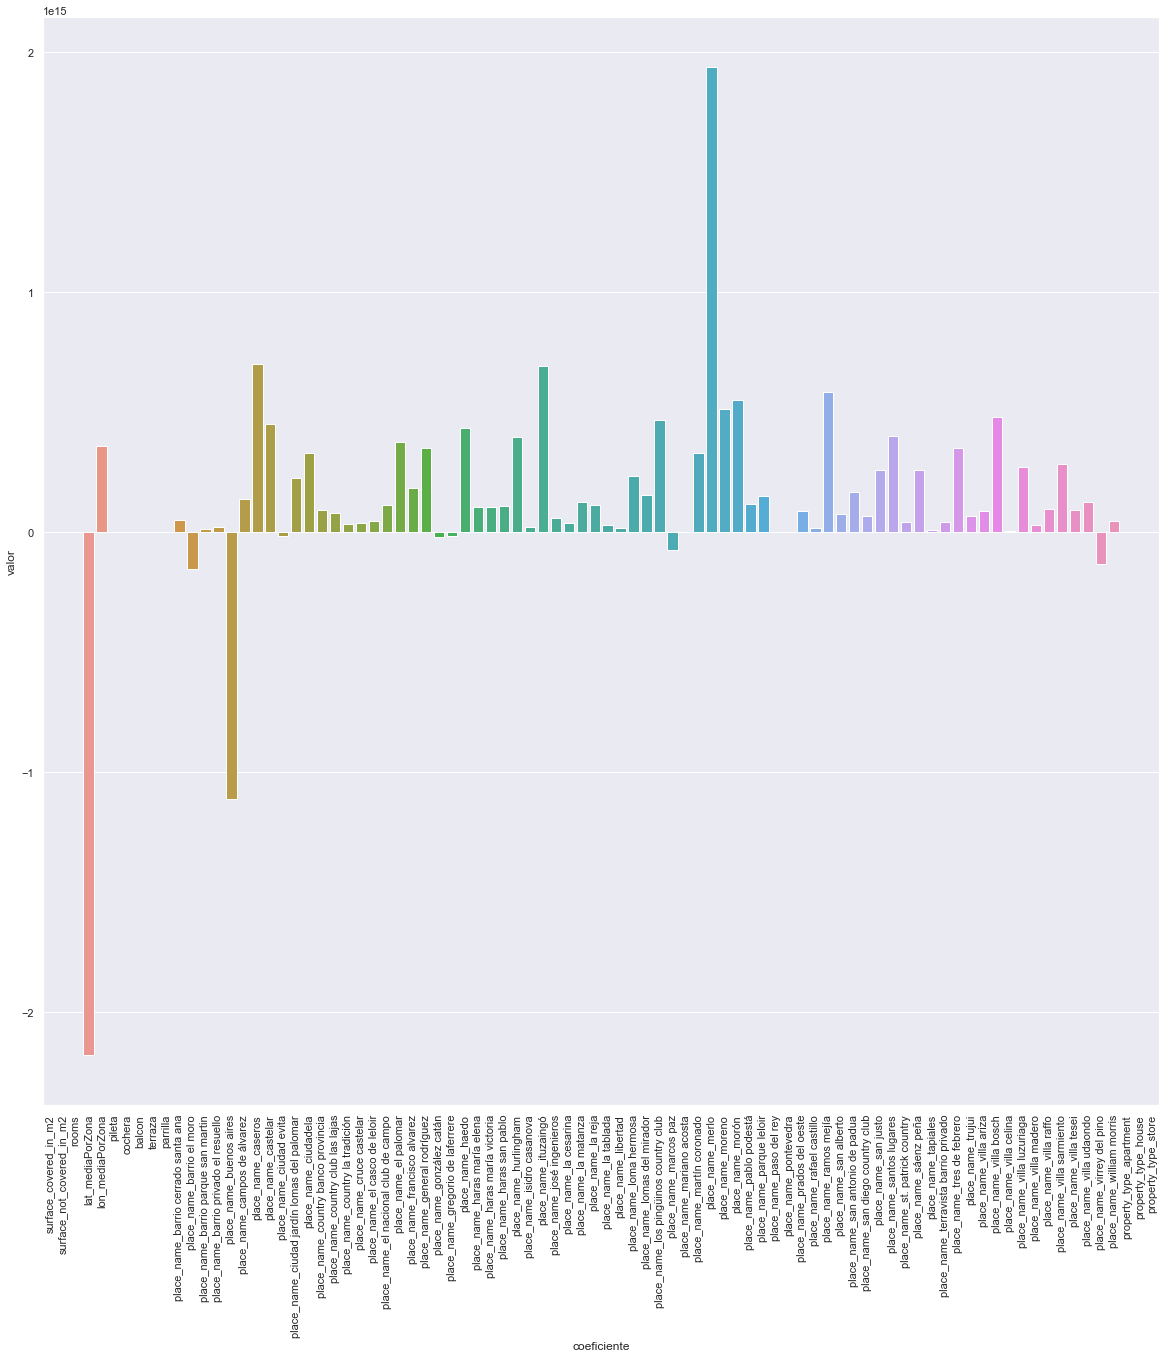

In [52]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [53]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

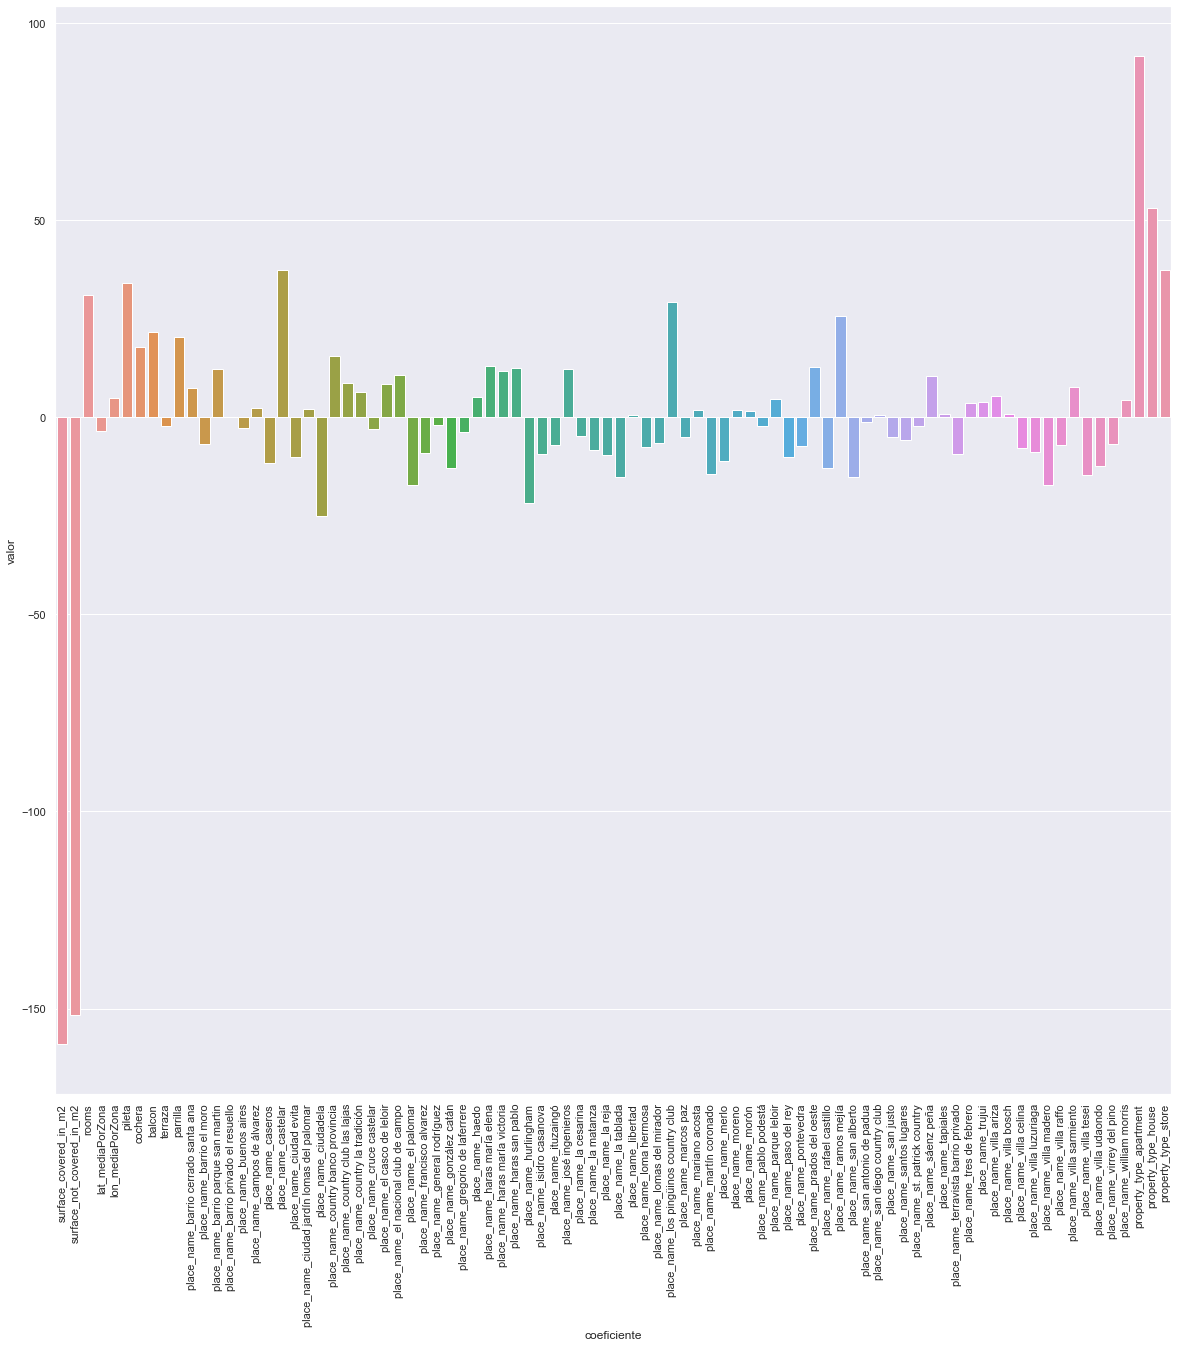

In [54]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [55]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

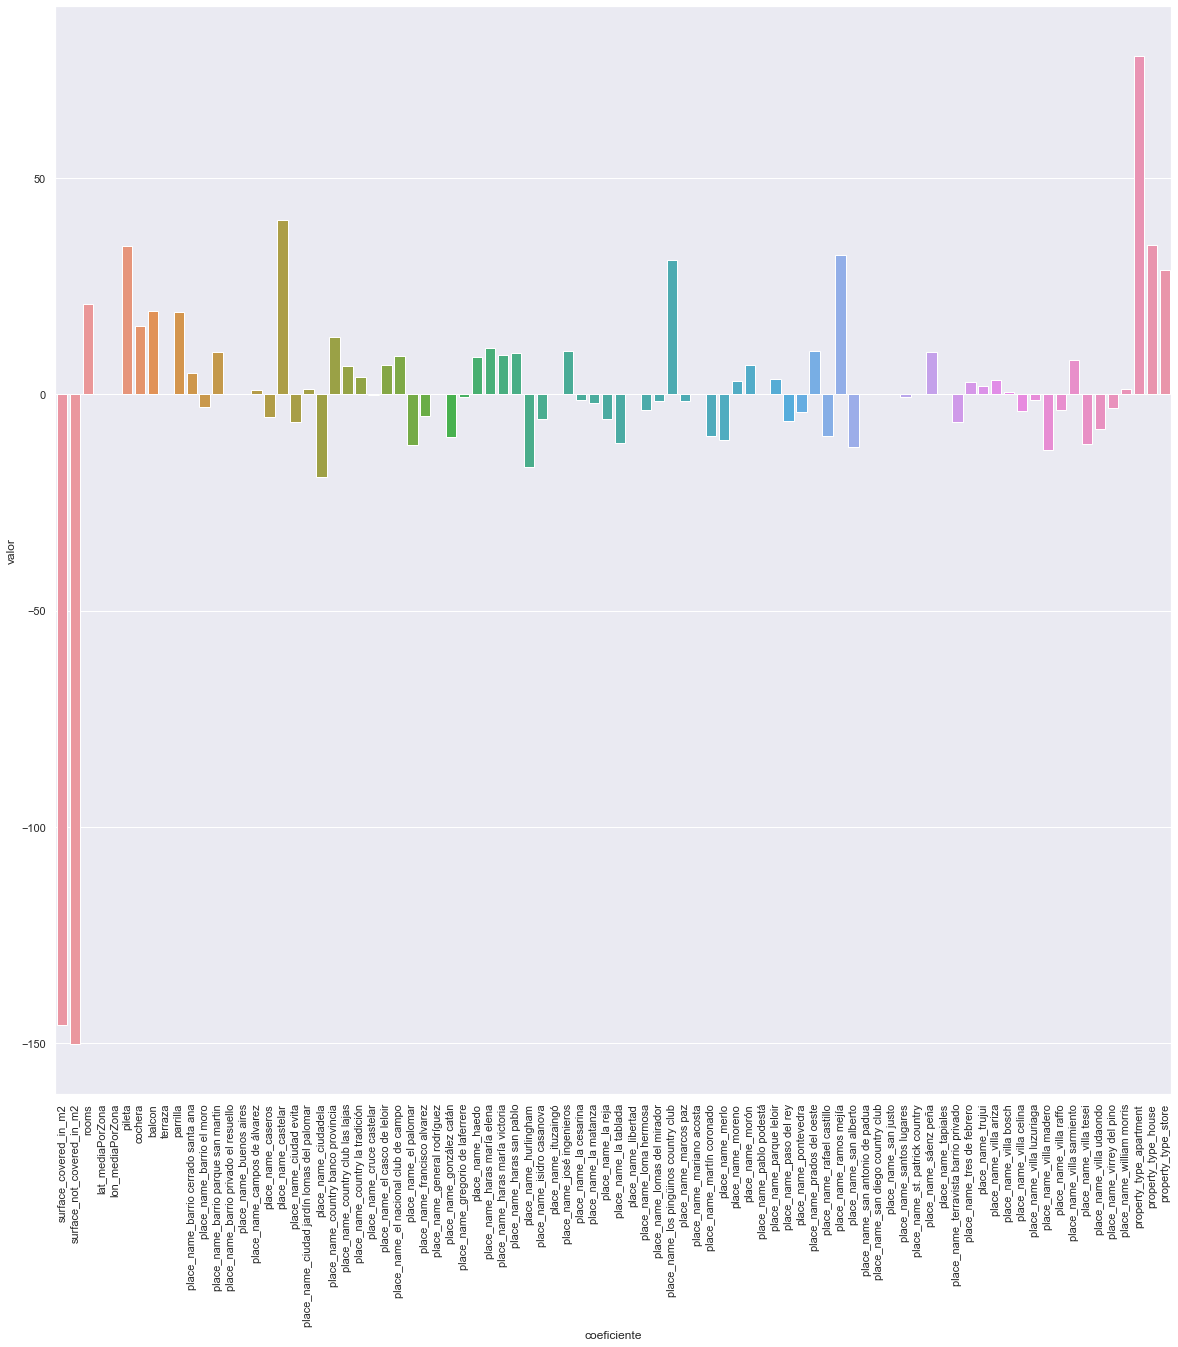

In [56]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20